# Modelos de Regresión y Clasificación II
Actividad Lección 4 || Fundamentos de IA y Machine Learning

Objetivos:
* Aplicar conceptos teóricos vistos en clase

Datos del alumno:
* Víctor Luque Martín
* Máster Avanzado en Programación en Python para Hacking, BigData y Machine Learning

Fecha: 21/10/2022

# Tabla de contenidos
1. [Preparación Previa](#pp)
2. [Problema I](#p1)
3. [Problema II](#p2)
4. [Problema III](#p3)

# Prepación Previa <a class="anchor" name="pp"></a>
- Importar librerías
- Definir función distancia euclídea

## Importar librerías <a class="anchor" name="pp-importar"></a>

In [523]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Distancia euclídea <a class="anchor" name="pp-distancia"></a>
Es la raíz cuadrada de las diferencias al cuadrado de cada una de las coordenadas de los puntos.

$$d_E(X_1,X_2) = \sqrt{\sum_{i=1}^{k} (X_{1i} - X_{2i})^2}$$

In [524]:
def distancia_euclidea(x1, x2):
    if len(x1) != len(x2):
        raise Exception("Las coordenadas deben tener la misma cantidad de elementos")
    k = len(x1)
    sumatorio = sum([(x1[i] - x2[i])**2 for i in range(k)])
    return sumatorio**0.5

# Problema I <a name="p1"></a>
Se pide agrupar un total de 8 patrones bidimensionales en tres clusters (𝑘 = 3). Los patrones son los siguientes: A1 (2,10), A2(2,5), A3(8,4), A4(5,8), A5(7,5),
A6(6,4), A7(1,2) y A8(4,9). Los centroides iniciales son los puntos A1, A3 y A4. La métrica de distancia utilizada será la distancia euclídea.
Se pide:
1. Representar los clusters creados y la posición de los centroides después de cada iteración.
2. El valor de la métrica SSE.
3. Comparar los resultados con los obtenidos en el ejemplo de la sección 2.3. del manual de la lección 5.
4. ¿Á que se debe la diferencia de resultados?

## Carga de datos <a class="anchor" name="p1-carga-datos"></a>
Se muestran de forma resaltada los puntos iniciales de los centroides (A1, A3, A4).

In [525]:
l5p1 = pd.read_csv("l5p1.csv")
l5p1

,coorX,coorY
0,2,10
1,2,5
2,8,4
3,5,8
4,7,5
5,6,4
6,1,2
7,4,9


## Representación de los datos <a class="anchor" name="p1-representacion"></a>

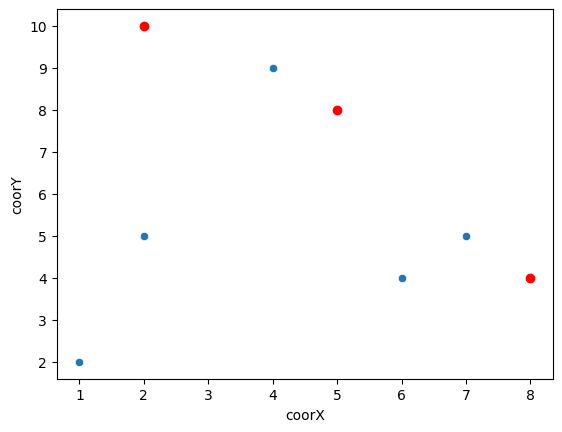

In [526]:
sns.scatterplot(x="coorX", y="coorY", data=l5p1)
# change color of points (2,10), (8,4), (5,8)
plt.scatter([2,8,5], [10,4,8], color="red")
plt.show()

In [527]:
def agrupamiento_particional(l5p1):
    c1, c2, c3 = (2,10), (8,4), (5,8)
    cambio = True
    result_df: pd.DataFrame = l5p1.copy()
    check_df: pd.DataFrame = l5p1.copy()
    i = 0
    # create a figure
    fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
    while cambio:
        distances_df = pd.DataFrame({
            "C1": [distancia_euclidea(row[["coorX", "coorY"]], c1) for _, row in result_df.iterrows()],
            "C2": [distancia_euclidea(row[["coorX", "coorY"]], c2) for _, row in result_df.iterrows()],
            "C3": [distancia_euclidea(row[["coorX", "coorY"]], c3) for _, row in result_df.iterrows()],
        })
        check_df["cluster"] = distances_df.idxmin(axis=1)
        if "cluster" in result_df.columns:
            cambio = not (result_df["cluster"] == check_df["cluster"]).all()
        result_df["cluster"] = distances_df.idxmin(axis=1)
        
        sns.scatterplot(x="coorX", y="coorY", hue="cluster", data=result_df, ax=ax[i])
        ax[i].scatter([c1[0],c2[0],c3[0]], [c1[1],c2[1],c3[1]], color=["blue", "green", "orange"], marker="x")
        ax[i].set_title(f"Iteración {i}")
        for j, txt in enumerate([c1, c2, c3]):
            ax[i].annotate(f"({round(txt[0], 2)}, {round(txt[1], 2)})", (txt[0]+0.1, txt[1]+0.1))
        i+=1
        c1 = tuple(result_df[result_df["cluster"] == "C1"][["coorX", "coorY"]].mean().to_list())
        c2 = tuple(result_df[result_df["cluster"] == "C2"][["coorX", "coorY"]].mean().to_list())
        c3 = tuple(result_df[result_df["cluster"] == "C3"][["coorX", "coorY"]].mean().to_list())          
    plt.show()
    # add coordinates of centroids
    result_df["centroid_x"] = result_df["cluster"].apply(lambda x: round(c1[0], 2) if x == "C1" else round(c2[0], 2) if x == "C2" else round(c3[0], 2))
    result_df["centroid_y"] = result_df["cluster"].apply(lambda x: round(c1[1], 2) if x == "C1" else round(c2[1], 2) if x == "C2" else round(c3[1], 2))
    return result_df

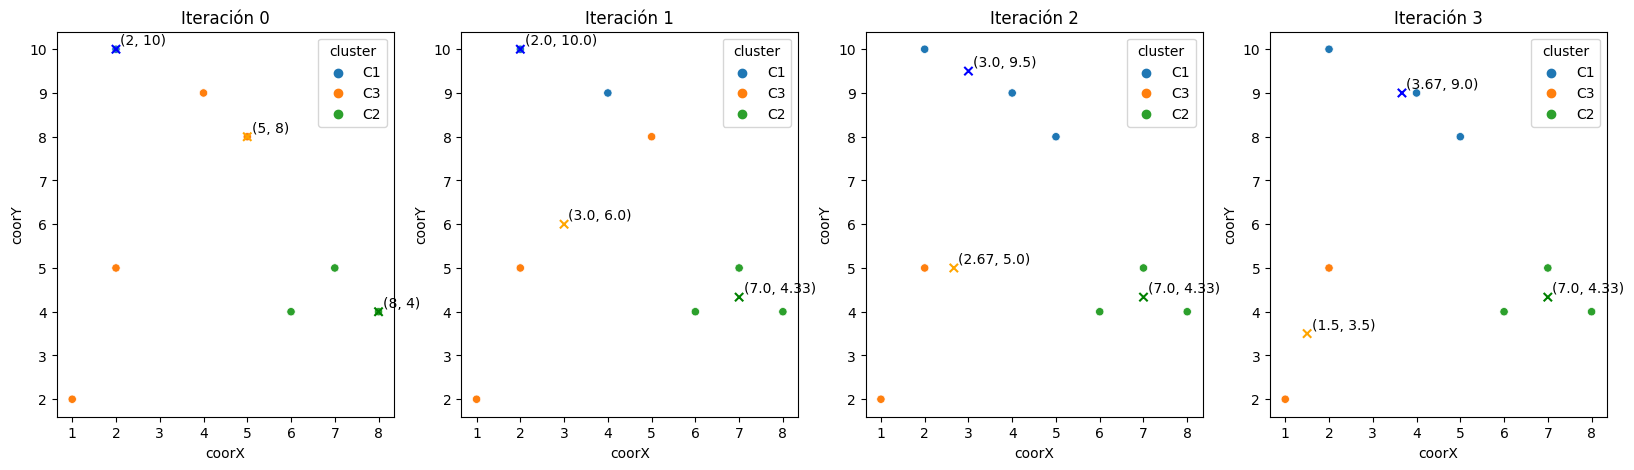

In [528]:
result_df = agrupamiento_particional(l5p1)

In [529]:
# add column distance to centroid
result_df["distancia_centroide"] = result_df.apply(lambda x: distancia_euclidea((x["coorX"], x["coorY"]), (x["centroid_x"], x["centroid_y"])), axis=1)
result_df

,coorX,coorY,cluster,centroid_x,centroid_y,distancia_centroide
0,2,10,C1,3.67,9.00,1.946510
1,2,5,C3,1.50,3.50,1.581139
2,8,4,C2,7.00,4.33,1.053043
3,5,8,C1,3.67,9.00,1.664001
4,7,5,C2,7.00,4.33,0.670000
5,6,4,C2,7.00,4.33,1.053043
6,1,2,C3,1.50,3.50,1.581139
7,4,9,C1,3.67,9.00,0.330000


In [530]:
sse = 0
for i, row in result_df.iterrows():
    sse += row["distancia_centroide"]**2
sse

14.333400000000003

# Problema II <a name="p2"></a>
Dada la siguiente matriz de distancias entre cinco patrones:

In [531]:
l5p2_df = pd.DataFrame({
    "A" : [0, 1, 2, 9, 10],
    "B" : [1, 0, 3, 7, 5],
    "C" : [2, 3, 0, 4, 6],
    "D" : [9, 7, 4, 0, 8],
    "E" : [10, 5, 6, 8, 0],
}, index=["A", "B", "C", "D", "E"])
l5p2_df


,A,B,C,D,E
A,0,1,2,9,10
B,1,0,3,7,5
C,2,3,0,4,6
D,9,7,4,0,8
E,10,5,6,8,0


Se pide:
1. Aplicar un clustering jerárquico con el método de enlace simple.
2. Aplicar un clustering jerárquico con el método de enlace completo.
3. ¿Se podría usar el método de enlace medio con estos datos? Justifica la respuesta.

In [532]:
def linkage(df, func):
    # merge clusters with the smallest distance
    merged = True
    result = {}
    while merged:
        merged = False
        min_dist = 100
        min_cluster = None
        for i, row in df.iterrows():
            for j, col in row.items():
                if i != j and col < min_dist:
                    min_dist = col
                    min_cluster = (i, j)
        if min_cluster:
            print(f"Merge {min_cluster} with distance {min_dist}")
            merged = True
            # merge clusters
            df[min_cluster[0]] = df[min_cluster[0]].combine(df[min_cluster[1]], func)
            df[min_cluster[1]] = df[min_cluster[0]]
            df = df.drop(min_cluster[1], axis=1)
            df = df.drop(min_cluster[1], axis=0)
            # replace column and row names
            df = df.rename(columns={min_cluster[0]: f"{min_cluster[0]}{min_cluster[1]}"}, index={min_cluster[0]: f"{min_cluster[0]}{min_cluster[1]}"})
            print(f"Clusters {min_cluster[0]} y {min_cluster[1]} unidos")
            print(df)
            print("")
            result[''.join(min_cluster)] = min_dist
    return result

In [533]:
linkage(l5p2_df.copy(), min)

Merge ('A', 'B') with distance 1
Clusters A y B unidos
    AB  C  D   E
AB   0  2  9  10
C    2  0  4   6
D    7  4  0   8
E    5  6  8   0

Merge ('AB', 'C') with distance 2
Clusters AB y C unidos
     ABC  D   E
ABC    0  9  10
D      4  0   8
E      5  8   0

Merge ('D', 'ABC') with distance 4
Clusters D y ABC unidos
      DABC  E
DABC     0  8
E        5  0

Merge ('E', 'DABC') with distance 5
Clusters E y DABC unidos
       EDABC
EDABC      0



{'AB': 1, 'ABC': 2, 'DABC': 4, 'EDABC': 5}

In [534]:
linkage(l5p2_df.copy(), max)

Merge ('A', 'B') with distance 1
Clusters A y B unidos
    AB  C  D   E
AB   1  2  9  10
C    3  0  4   6
D    9  4  0   8
E   10  6  8   0

Merge ('AB', 'C') with distance 2
Clusters AB y C unidos
     ABC  D   E
ABC    2  9  10
D      9  0   8
E     10  8   0

Merge ('D', 'E') with distance 8
Clusters D y E unidos
     ABC  DE
ABC    2  10
DE     9   8

Merge ('DE', 'ABC') with distance 9
Clusters DE y ABC unidos
       DEABC
DEABC      9



{'AB': 1, 'ABC': 2, 'DE': 8, 'DEABC': 9}

In [535]:
# average linkage
linkage(l5p2_df.copy(), lambda x, y: (x+y)/2)

Merge ('A', 'B') with distance 1
Clusters A y B unidos
     AB  C  D   E
AB  0.5  2  9  10
C   2.5  0  4   6
D   8.0  4  0   8
E   7.5  6  8   0

Merge ('AB', 'C') with distance 2.0
Clusters AB y C unidos
      ABC  D   E
ABC  1.25  9  10
D    6.00  0   8
E    6.75  8   0

Merge ('D', 'ABC') with distance 6.0
Clusters D y ABC unidos
       DABC  E
DABC  3.000  8
E     7.375  0

Merge ('E', 'DABC') with distance 7.375
Clusters E y DABC unidos
        EDABC
EDABC  3.6875



{'AB': 1, 'ABC': 2.0, 'DABC': 6.0, 'EDABC': 7.375}

# Problema III <a name="p3"></a>
Dados los mismos puntos del Problema I.
Se pide:
1. Aplicar DBSCAN considerando 𝑀 = 3 y ϵ = $\sqrt{2}$.
2. Aplicar DBSCAN considerando 𝑀 = 3 y ϵ = $\sqrt{10}$.
3. ¿En qué afecta el cambio del parámetro ϵ ?

In [536]:
l5p3_df = l5p1.copy()
l5p3_df

,coorX,coorY
0,2,10
1,2,5
2,8,4
3,5,8
4,7,5
5,6,4
6,1,2
7,4,9


In [537]:
def get_neighbors(df, point, eps):
    neighbours = []
    for i, row in df.iterrows():
        if distancia_euclidea(point, row[["coorX", "coorY"]]) < eps:
            neighbours.append(i)
    return neighbours

In [538]:
def dbscan(df, m, epsilon):
    clusters = {}
    noise = []
    visited = []
    cluster_id = 0
    for i, row in df.iterrows():
        # if point is not visited
        if i not in visited:
            # mark as visited
            visited.append(i)
            # get neighbors
            neighbors = get_neighbors(df, row, epsilon)
            # if point is not a core point
            if len(neighbors) < m:
                # mark as noise
                noise.append(i)
            else:
                # create a new cluster
                cluster_id += 1
                clusters[cluster_id] = []
                # add point to cluster
                clusters[cluster_id].append(i)
                # for each neighbor
                for j in neighbors:
                    # if neighbor is not visited
                    if j not in visited:
                        # mark as visited
                        visited.append(j)
                        # get neighbors of neighbor
                        neighbors2 = get_neighbors(df, row, epsilon)
                        # if neighbor is a core point
                        if len(neighbors2) >= m:
                            # add neighbors of neighbor to neighbors
                            neighbors += neighbors2
                    # if neighbor is not assigned to a cluster
                    if j not in clusters[cluster_id]:
                        # add neighbor to cluster
                        clusters[cluster_id].append(j)
    return clusters, noise

In [539]:
dbscan(l5p3_df, m=3, epsilon=2**0.5)

({}, [0, 1, 2, 3, 4, 5, 6, 7])

In [540]:
dbscan(l5p3_df, m=3, epsilon=10**0.5)

({1: [2, 4, 5], 2: [7, 0, 3]}, [0, 1, 3, 6])